## Imports and data loading

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor as kNN_reg
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error
import tensorflow as tf
%matplotlib inline 

plt.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    "font.serif": ["Palatino"],
    "font.size": 10,
})

def RMSE(true, predicted):
    MSE = mean_squared_error(true, predicted)
    return np.round(np.sqrt(MSE), decimals=4)

import os
os.chdir("../")


cwd = os.getcwd()
print(cwd)


REPORT_PATH = "FYS-STK4155-Prj1_report"
INPUT_PATH = "code/data_input/"
OUTPUT_PATH = "code/data_output/"

C:\Users\andre\Dropbox\FYS-STK4155_projects\FYS-STK4155 - Project1\FYS-STK4155-Prj1_report


In [2]:
# Training data
training_data = pd.read_csv(f"{INPUT_PATH}TrainData.csv")

# Forecast input data
forecast_data = pd.read_csv(f"{INPUT_PATH}WeatherForecastInput.csv")

# Forecast solution
forecast_solution = pd.read_csv(f"{INPUT_PATH}Solution.csv")

# Extract numpy arrays for wind speed and power.
x_train = training_data["WS10"].to_numpy().reshape(-1, 1)
y_train = training_data["POWER"].to_numpy().reshape(-1, 1)

x_f = forecast_data["WS10"].to_numpy().reshape(-1, 1)
y_f = forecast_solution["POWER"].to_numpy().reshape(-1, 1);

## Correlation analysis

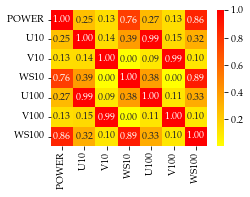

In [3]:
# Create correlation matrix
corr_matrix = training_data.corr(method='spearman')
# Plot
fig, axs = plt.subplots(1, 1, figsize=(3.5, 2.5))
sns.heatmap(abs(corr_matrix), annot=True, cmap = plt.cm.autumn_r, fmt='.2f', ax=axs)
plt.savefig(f"figures/q1_corr_analysis.pdf", bbox_inches='tight');
#plt.savefig(f"{REPORT_PATH}/figures/q1_corr_analysis.pdf", bbox_inches='tight');

# Prepare results and figures

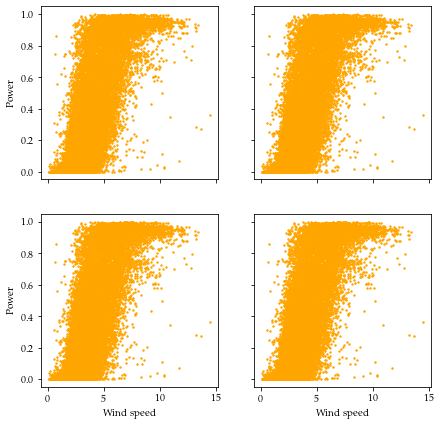

In [4]:
# We store the root-mean-square errors in a dictionary.
RMSE_dict = {}

# Prepare a 2x2 figure grid to plot predicted versus real data for the testing data.
fig, axs = plt.subplots(2, 2, figsize=(7, 7), sharex=True, sharey=True)
axs[1, 1].set_xlabel("Wind speed")
axs[1, 0].set_xlabel("Wind speed")
axs[0, 0].set_ylabel("Power")
axs[1, 0].set_ylabel("Power");

for ax in axs.flatten():
    ax.scatter(x_train, y_train, color="orange", s=2, label="Training data");
    #ax.scatter(x_train, y_train, color="green", s=2, label="Training data");

# Linear regression

In [5]:
# Building the model.
LR_model = LinearRegression()

# Training the model.
LR_model.fit(x_train, y_train)

# Use the model for forcast power output for November.
y_f_hat_LR = LR_model.predict(x_f) 

# Compute the RMSE.
RMSE_dict["Linear regression"] = RMSE(y_f, y_f_hat_LR)

# Plot the forecast power output function versus the real data for November.
axs[0, 0].scatter(x_f, y_f, color="slateblue", s=5, label="Test data")
axs[0, 0].scatter(x_f, y_f_hat_LR, color="r", s=5, label="Predicted data")
axs[0, 0].set_title("Linear regression")
axs[0, 0].legend()

# Save the forecast in a CSV file
forecast_LR = pd.read_csv(f"{INPUT_PATH}ForecastTemplate.csv", index_col=0)
forecast_LR["FORECAST"] = y_f_hat_LR
forecast_LR.to_csv(f"{OUTPUT_PATH}Forecast-LR.csv")

# k-nearest neighbor regression 
Regression based on k-nearest neighbors. The target is predicted by local interpolation of the targets associated of the nearest neighbors in the training set. https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsRegressor.html

In [6]:
# The number of neighbours to consider.
k = 1000

# Building the model.
kNN_reg_model = kNN_reg(n_neighbors = k) 

# Training the model.
kNN_reg_model.fit(x_train, y_train)

# Calculate the model score using RMSE
y_f_hat_kNN_reg = kNN_reg_model.predict(x_f)
RMSE_dict["kNN"] = RMSE(y_f, y_f_hat_kNN_reg)

# Plot results on testing data.
axs[0, 1].scatter(x_f, y_f, color="slateblue", s=5, label="Test data")
axs[0, 1].scatter(x_f, y_f_hat_kNN_reg, color="r", s=5, label="Predicted data")
axs[0, 1].set_title("kNN predictions")

# Save the forecast in a CSV file.
forecast_kNN = pd.read_csv(f"{INPUT_PATH}ForecastTemplate.csv", index_col=0)
forecast_kNN["FORECAST"] = y_f_hat_kNN_reg
forecast_kNN.to_csv(f"{OUTPUT_PATH}Forecast-kNN.csv")

# Support vector regression 

In [7]:
# Building the model.
SVR_model = SVR(kernel='rbf', C=1.0, epsilon=0.05) 

# Training the model.
SVR_model.fit(x_train, y_train.flatten())

# Calculate the model score using RMSE
y_f_hat_SVR = SVR_model.predict(x_f)
RMSE_dict["SVR"] = RMSE(y_f, y_f_hat_SVR)

# Plot results on testing data.
axs[1, 0].scatter(x_f, y_f, color="slateblue", s=5, label="Test data")
axs[1, 0].scatter(x_f, y_f_hat_SVR, color="r", s=5, label="Predicted data")
axs[1, 0].set_title(f"SVR predictions")

# Save the forecast in a CSV file.
forecast_SVR = pd.read_csv(f"{INPUT_PATH}ForecastTemplate.csv", index_col=0)
forecast_SVR["FORECAST"] = y_f_hat_SVR
forecast_SVR.to_csv(f"{OUTPUT_PATH}Forecast-SVR.csv")

# Neural network regression 


In [8]:
# Building the model
ANN_model = tf.keras.models.Sequential([
  tf.keras.layers.Input(shape=(1,)),
  tf.keras.layers.Dense(15, activation='tanh'),
  tf.keras.layers.Dense(1)
])

ANN_model.compile(loss=tf.keras.losses.mean_squared_error,
                         optimizer=tf.optimizers.Adam(learning_rate=0.001))

# Training the model
training = ANN_model.fit(x_train, y_train, epochs=50, verbose=0)

# Calculate the model score using RMSE
y_f_hat_ANN = ANN_model.predict(x_f)
RMSE_dict["ANN"] = RMSE(y_f, y_f_hat_ANN)

# Plot results on testing data.
axs[1, 1].scatter(x_f, y_f, color="slateblue", s=5, label="Test data")
axs[1, 1].scatter(x_f, y_f_hat_ANN, color="r", s=5, label="Predicted data")
axs[1, 1].set_title(f"ANN predictions")

# Save the forecast in a CSV file.
forecast_ANN = pd.read_csv(f"{INPUT_PATH}ForecastTemplate.csv", index_col=0)
forecast_ANN["FORECAST"] = y_f_hat_ANN
forecast_ANN.to_csv(f"{OUTPUT_PATH}Forecast-NN.csv")

# Prepare results

In [12]:
# Save the figure.
#fig.savefig(f"{REPORT_PATH}/figures/q1_prediction_plots.png", dpi=300, bbox_inches='tight')
fig.savefig(f"figures/q1_prediction_plots.png", dpi=300, bbox_inches='tight')

# Save the RMSEs.
pd.Series(RMSE_dict, name="RMSE").to_csv(f"data/q1_RMSE.csv")
#pd.Series(RMSE_dict, name="RMSE").to_csv(f"{REPORT_PATH}/data/q1_RMSE.csv")

### Model performance visualization

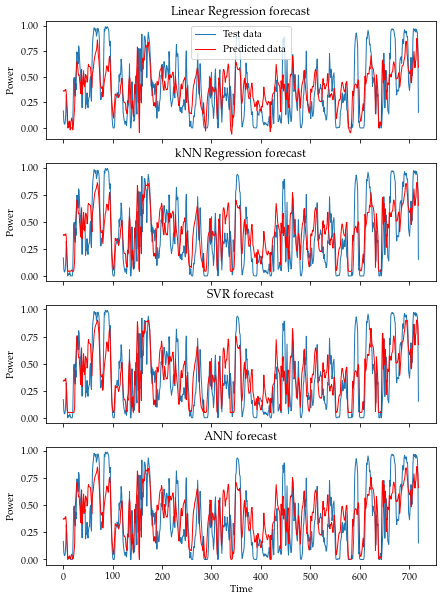

In [13]:
fig2, axs2 = plt.subplots(4, 1, figsize=(7, 10), sharex=True)
axs2[3].set_xlabel("Time")
for i in range(4):
    axs2[i].set_ylabel("Power")

# Linear Regression
axs2[0].plot(np.arange(x_f.shape[0]), y_f, linewidth=1,  label="Test data")
axs2[0].plot(np.arange(x_f.shape[0]), y_f_hat_LR, linewidth=1, color="r", label="Predicted data")
axs2[0].set_title(f"Linear Regression forecast")
axs2[0].legend()

# kNN regression
axs2[1].plot(np.arange(x_f.shape[0]), y_f, linewidth=1,  label="Test data")
axs2[1].plot(np.arange(x_f.shape[0]), y_f_hat_kNN_reg, linewidth=1, color="r", label="Predicted data")
axs2[1].set_title(f"kNN Regression forecast")

# SVR
axs2[2].plot(np.arange(x_f.shape[0]), y_f, linewidth=1,  label="Test data")
axs2[2].plot(np.arange(x_f.shape[0]), y_f_hat_SVR, linewidth=1, color="r", label="Predicted data")
axs2[2].set_title(f"SVR forecast")

# ANN
axs2[3].plot(np.arange(x_f.shape[0]), y_f, linewidth=1,  label="Test data")
axs2[3].plot(np.arange(x_f.shape[0]), y_f_hat_ANN, linewidth=1, color="r", label="Predicted data")
axs2[3].set_title(f"ANN forecast")

# Save the figure.
fig2.savefig(f"figures/q1_forecast_plots.pdf", bbox_inches='tight')

# Additional analysis

In [ ]:
# Compute the RMSE of the models on the training data instead of the forecast data
RMSE_training_dict = {}

y_train_hat_LR = LR_model.predict(x_train)
RMSE_training_dict["LR"] = RMSE(y_train, y_train_hat_LR)

y_train_hat_kNN = kNN_reg_model.predict(x_train)
RMSE_training_dict["kNN"] = RMSE(y_train, y_train_hat_kNN)

y_train_hat_SVR = SVR_model.predict(x_train)
RMSE_training_dict["SVR"] = RMSE(y_train, y_train_hat_SVR)

y_train_hat_ANN = ANN_model.predict(x_train)
RMSE_training_dict["ANN"] = RMSE(y_train, y_train_hat_ANN)

pd.Series(RMSE_training_dict, name="RMSE on training").to_csv(f"data/q1_RMSE_training.csv")

In [ ]:
# Perform a quick polynomial regression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import Pipeline
poly_model = Pipeline([('poly', PolynomialFeatures(degree=3)),
                       ('linear', LinearRegression(fit_intercept=False))])
poly_model.fit(x_train, y_train)
y_train_hat_poly = poly_model.predict(x_train)
with open(f"data/q1_RMSE_poly_training.txt", "w") as f:
    f.write(f"{RMSE(y_train, y_train_hat_poly)}%")

## Data for Question 2
We need the RMSE for the linear regression for Question 2.

In [ ]:
with open(f"data/q1_RMSE_LR.txt", "w") as f:
    f.write(f"{RMSE_dict['Linear regression']}%")